In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn tensorflow flask


In [2]:
import yfinance as yf
import pandas as pd

# Define the stock symbol and date range
stock_symbol = "AAPL"  # Example: Apple Inc.
start_date = "2015-01-01"
end_date = "2025-01-01"

# Fetch the stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Save the data to a CSV file for further processing
stock_data.to_csv("stock_data.csv")

print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.347170  24.817055  23.906234  24.805920  212818400
2015-01-05  23.661272  24.195739  23.474210  24.115569  257142000
2015-01-06  23.663498  23.924050  23.300505  23.725852  263188400
2015-01-07  23.995319  24.095531  23.761490  23.872837  160423600
2015-01-08  24.917269  24.975170  24.206873  24.324903  237458000


In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
df = pd.read_csv("stock_data.csv", index_col=0, parse_dates=True)

# Drop columns that are not needed
df = df[['Close']]  # We'll use only the closing price

# Handle missing values
df.dropna(inplace=True)

# The problem: The index likely contains the stock symbol 'AAPL'
# Solution: Explicitly drop the row containing 'AAPL' from the index
#           Check if 'AAPL' is in the index, and if so, drop it.
#           The current implementation is incorrect, should check index values.
#           Using df[df.index == 'AAPL'] to get a boolean index,
#           then using ~ to invert it to select the rows that are not 'AAPL'.
df = df[~df.index.isin(['AAPL'])] # This filters out the row with 'AAPL' as index.

# Convert the 'Close' column to numeric, handling errors
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop rows with NaN values that may have arisen from the conversion
df.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

print(f"Training data size: {len(train_data)}, Testing data size: {len(test_data)}")

Training data size: 2012, Testing data size: 504


<ipython-input-8-2a2c174eaa07>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("stock_data.csv", index_col=0, parse_dates=True)


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert the data into a supervised learning format
def create_features(data, n_lags=5):
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data[i:i + n_lags])
        y.append(data[i + n_lags])
    return np.array(X), np.array(y)

# Define the number of previous days to consider
n_lags = 5

# Prepare features for training and testing
X_train, y_train = create_features(train_data['Close'].values, n_lags)
X_test, y_test = create_features(test_data['Close'].values, n_lags)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict future stock prices
lr_predictions = lr_model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, lr_predictions)
rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print(f"Linear Regression - MAE: {mae:.5f}, RMSE: {rmse:.5f}")


Linear Regression - MAE: 0.00800, RMSE: 0.01076


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM (samples, time_steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_lags, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test))

# Predict future stock prices
lstm_predictions = lstm_model.predict(X_test_lstm)

# Evaluate performance
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

print(f"LSTM - MAE: {lstm_mae:.5f}, RMSE: {lstm_rmse:.5f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0402 - val_loss: 7.5136e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3578e-04 - val_loss: 4.6758e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4270e-04 - val_loss: 4.6845e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4855e-04 - val_loss: 6.6673e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3202e-04 - val_loss: 4.3910e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3724e-04 - val_loss: 5.0916e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5284e-04 - val_loss: 4.1386e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4414e-04 - val_loss: 6.1961e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.3993e-04 - val_loss: 4.2226e-04
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4057e-04 - val_loss: 6.5071e-04
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 

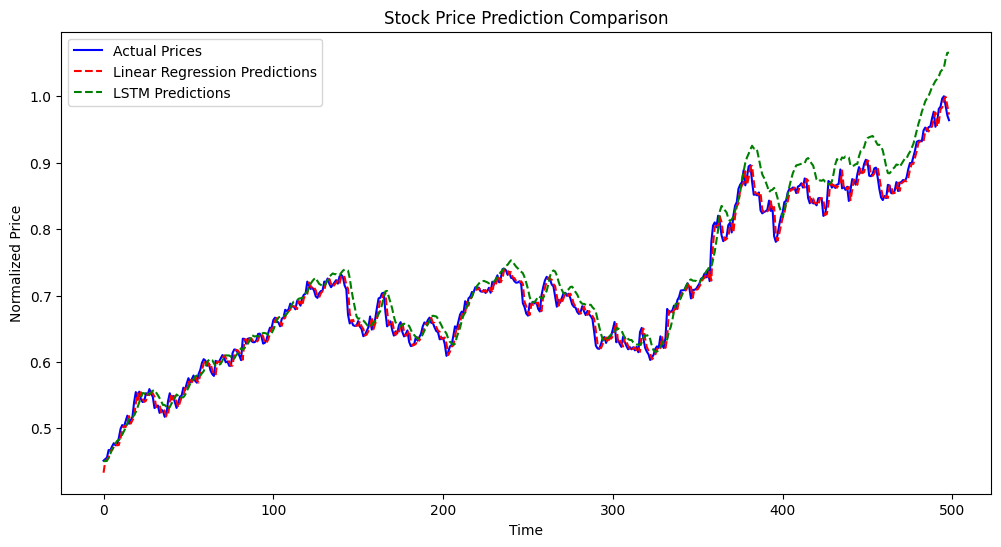

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(y_test, label="Actual Prices", color="blue")
plt.plot(lr_predictions, label="Linear Regression Predictions", linestyle="dashed", color="red")
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="dashed", color="green")

plt.xlabel("Time")
plt.ylabel("Normalized Price")
plt.title("Stock Price Prediction Comparison")
plt.legend()
plt.show()


In [12]:
import joblib

# Save Linear Regression model
joblib.dump(lr_model, "linear_regression.pkl")

# Save the MinMaxScaler
joblib.dump(scaler, "scaler.pkl")

# Save LSTM model
lstm_model.save("lstm_model.h5")
